#INTRODUCTION TO REINFORCEMENT LEARNING

Deep RL is a type of Machine Learning where an agent learns how to behave in an environment by performing actions and seeing the results.

In this first unit, you’ll learn the foundations of Deep Reinforcement Learning.

Then, you’ll train your Deep Reinforcement Learning agent, a lunar lander to land correctly on the Moon using Stable-Baselines3 , a Deep Reinforcement Learning library.

The big picture
The idea behind Reinforcement Learning is that an agent (an AI) will learn from the environment by interacting with it (through trial and error) and receiving rewards (negative or positive) as feedback for performing actions.

Learning from interactions with the environment comes from our natural experiences.

For instance, imagine putting your little brother in front of a video game he never played, giving him a controller, and leaving him alone.

By interacting with his environment through trial and error, your little brother understands that he needs to get coins in this environment but avoid the enemies.

Without any supervision, the child will get better and better at playing the game.

That’s how humans and animals learn, through interaction. Reinforcement Learning is just a computational approach of learning from actions.


Reinforcement learning is a framework for solving control tasks (also called decision problems) by building agents that learn from the environment by interacting with it through trial and error and receiving rewards (positive or negative) as unique feedback.

Markov Property
In papers, you’ll see that the RL process is called a Markov Decision Process (MDP).

We’ll talk again about the Markov Property in the following units. But if you need to remember something today about it, it’s this: the Markov Property implies that our agent needs only the current state to decide what action to take and not the history of all the states and actions they took before.


1. Episodic task
In this case, we have a starting point and an ending point (a terminal state). This creates an episode: a list of States, Actions, Rewards, and new States.

For instance, think about Super Mario Bros: an episode begin at the launch of a new Mario Level and ends when you’re killed or you reached the end of the level.

2. Continuing tasks
These are tasks that continue forever (no terminal state). In this case, the agent must learn how to choose the best actions and simultaneously interact with the environment.

For instance, an agent that does automated stock trading. For this task, there is no starting point and terminal state. The agent keeps running until we decide to stop it.

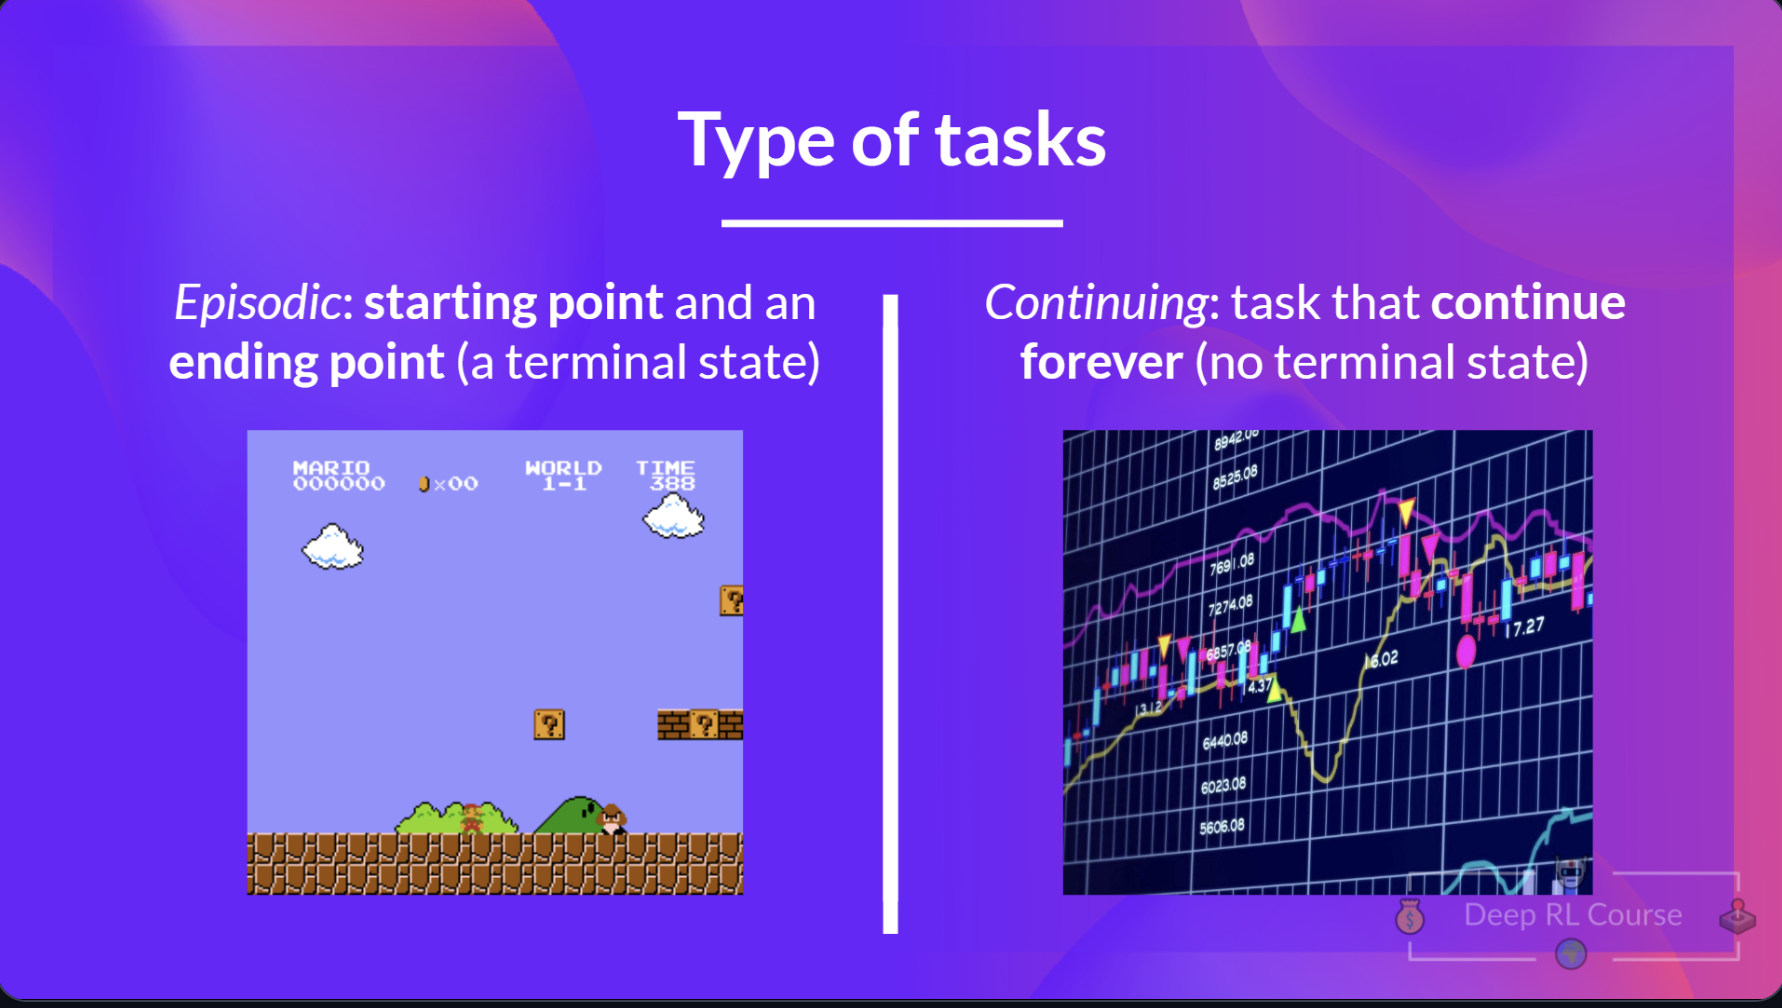

In [1]:
%%html
<video controls autoplay><source src="https://huggingface.co/sb3/ppo-LunarLander-v2/resolve/main/replay.mp4" type="video/mp4"></video>

# Install dependencies and create a virtual screen

In [1]:
!apt install swig cmake
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt


#During the notebook, we'll need to generate a replay video. To do so, with colab, we need to have a virtual screen to be able to render the environment
!sudo apt-get update
!sudo apt-get install -y python3-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (829 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

To make sure the new installed libraries are used, sometimes it's required to restart the notebook runtime. The next cell will force the runtime to crash, so you'll need to connect again and run the code starting from here. Thanks to this trick, we will be able to run our virtual screen.

In [ ]:
import os

os.kill(os.getpid(), 9)

In [1]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

# Import the packages

In [2]:
import gymnasium

from huggingface_sb3 import load_from_hub, package_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

Understand Gymnasium and how it works 🤖
🏋 The library containing our environment is called Gymnasium. You’ll use Gymnasium a lot in Deep Reinforcement Learning.

Gymnasium is the new version of Gym library maintained by the Farama Foundation.

The Gymnasium library provides two things:

An interface that allows you to create RL environments.
A collection of environments (gym-control, atari, box2D…).
Let’s look at an example, but first let’s recall the RL loop.

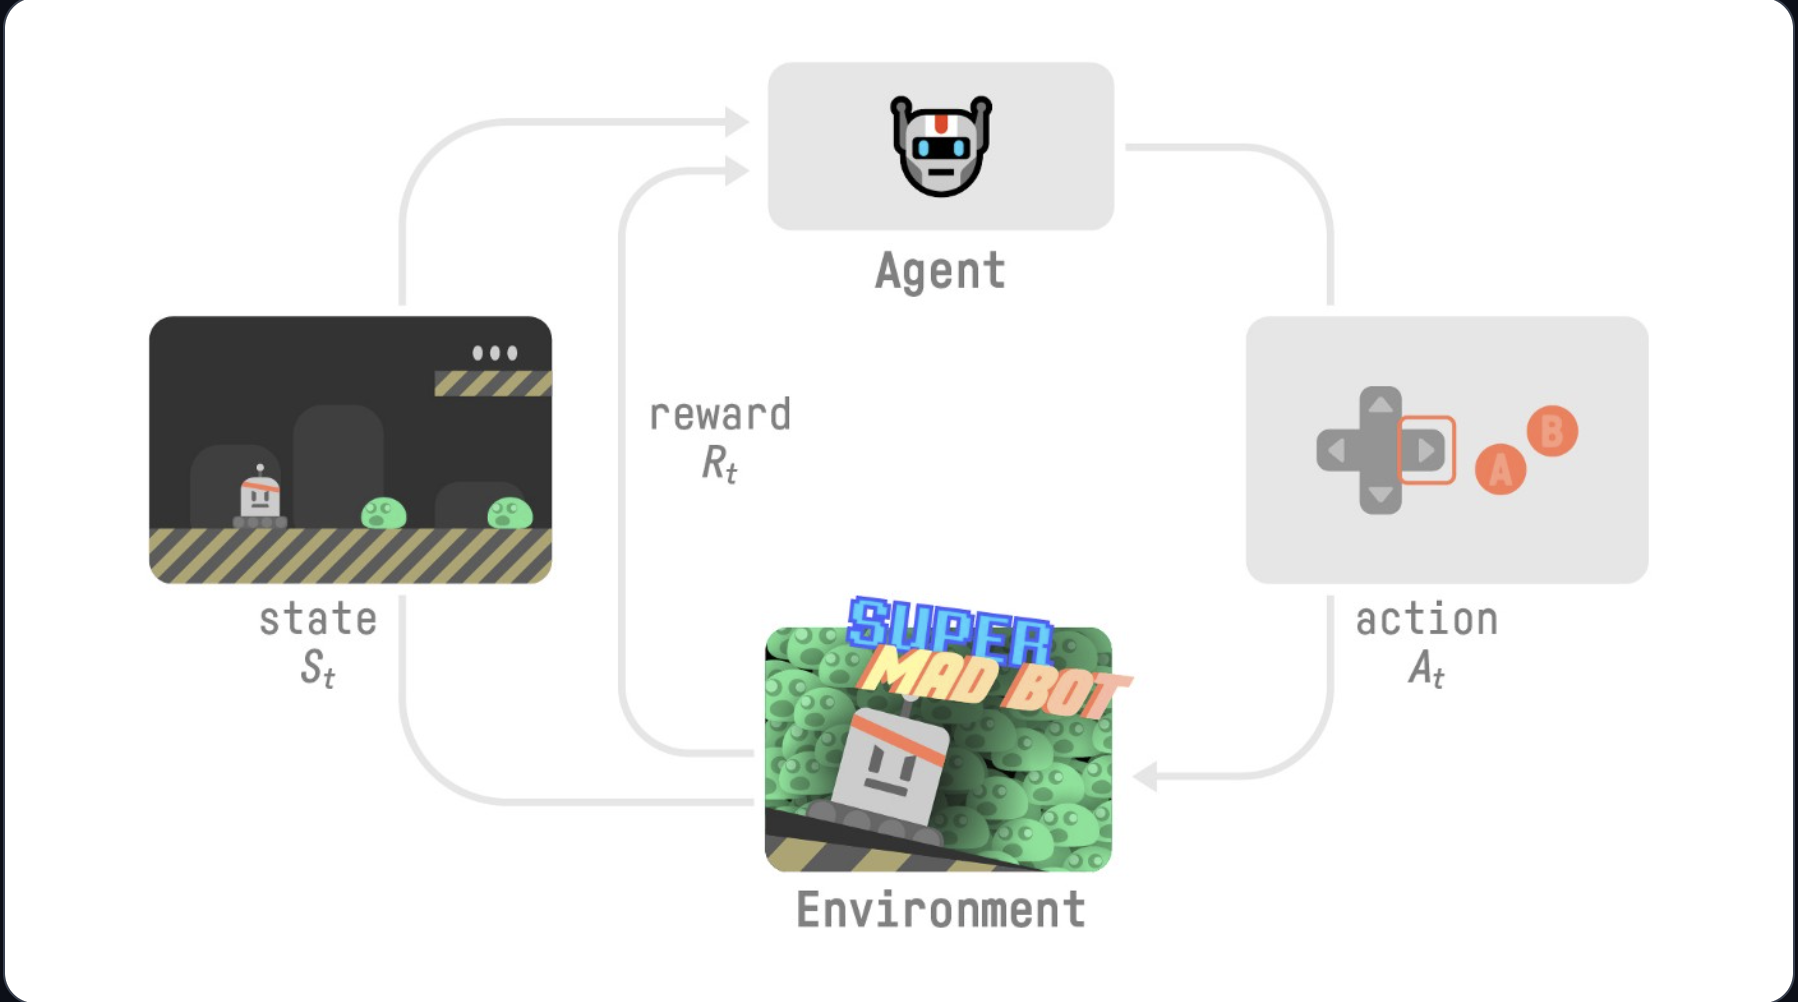

At each step:
- Our Agent receives a **state (S0)** from the **Environment** — we receive the first frame of our game (Environment).
- Based on that **state (S0),** the Agent takes an **action (A0)** — our Agent will move to the right.
- The environment transitions to a **new** **state (S1)** — new frame.
- The environment gives some **reward (R1)** to the Agent — we’re not dead *(Positive Reward +1)*.


With Gymnasium:

1️⃣ We create our environment using `gymnasium.make()`

2️⃣ We reset the environment to its initial state with `observation = env.reset()`

At each step:

3️⃣ Get an action using our model (in our example we take a random action)

4️⃣ Using `env.step(action)`, we perform this action in the environment and get
- `observation`: The new state (st+1)
- `reward`: The reward we get after executing the action
- `terminated`: Indicates if the episode terminated (agent reach the terminal state)
- `truncated`: Introduced with this new version, it indicates a timelimit or if an agent go out of bounds of the environment for instance.
- `info`: A dictionary that provides additional information (depends on the environment).

For more explanations check this 👉 https://gymnasium.farama.org/api/env/#gymnasium.Env.step

If the episode is terminated:
- We reset the environment to its initial state with `observation = env.reset()`

**Let's look at an example!** Make sure to read the code

LunarLander-v2 (Discrete)

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

LunarLander-v2 is a scenario developed by Oleg Klimov, an engineer at OpenAI, inspired by the original Atari Lunar Lander (https://github.com/olegklimov). In the implementation, you have to take your landing pod to a lunar pad that is always located at coordinates x=0 and y=0. In addition, your actual x and y position is known since their values are stored in the first two elements of the state vector, the vector that contains all the information for the reinforcement learning algorithm to decide the best action to take at a certain moment.
Source: https://learning.oreilly.com/library/view/tensorflow-deep-learning/9781788398060/04be3bfb-74a9-44eb-8ecb-de954e7696fb.xhtml

In [3]:
import gymnasium as gym

# First, we create our environment called LunarLander-v2
env = gym.make("LunarLander-v2")

# Then we reset this environment
observation, info = env.reset()

for _ in range(20):
  # Take a random action
  action = env.action_space.sample()
  print("Action taken:", action)

  # Do this action in the environment and get
  # next_state, reward, terminated, truncated and info
  observation, reward, terminated, truncated, info = env.step(action)

  # If the game is terminated (in our case we land, crashed) or truncated (timeout)
  if terminated or truncated:
      # Reset the environment
      print("Environment is reset")
      observation, info = env.reset()

env.close()

Action taken: 0
Action taken: 2
Action taken: 3
Action taken: 1
Action taken: 3
Action taken: 1
Action taken: 3
Action taken: 3
Action taken: 0
Action taken: 3
Action taken: 1
Action taken: 0
Action taken: 2
Action taken: 1
Action taken: 1
Action taken: 2
Action taken: 0
Action taken: 1
Action taken: 2
Action taken: 2


## Create the LunarLander environment 🌛 and understand how it works

### [The environment 🎮](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

In this first tutorial, we’re going to train our agent, a [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/), **to land correctly on the moon**. To do that, the agent needs to learn **to adapt its speed and position (horizontal, vertical, and angular) to land correctly.**

---


💡 A good habit when you start to use an environment is to check its documentation

👉 https://gymnasium.farama.org/environments/box2d/lunar_lander/

---


In [4]:
# We create our environment with gym.make("<name_of_the_environment>")
env = gym.make("LunarLander-v2")
env.reset()
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space Shape", env.observation_space.shape)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Shape (8,)
Sample observation [-20.141338   -59.90314      4.230214     0.14666176  -1.7034489
  -4.502537     0.61853015   0.20563099]


#### Vectorized Environment

- We create a vectorized environment (a method for stacking multiple independent environments into a single environment) of 16 environments, this way, **we'll have more diverse experiences during the training.**

In [5]:
# Create the environment
env = make_vec_env('LunarLander-v2', n_envs=16)

## Create the Model 🤖
- We have studied our environment and we understood the problem: **being able to land the Lunar Lander to the Landing Pad correctly by controlling left, right and main orientation engine**. Now let's build the algorithm we're going to use to solve this Problem 🚀.

- To do so, we're going to use our first Deep RL library, [Stable Baselines3 (SB3)](https://stable-baselines3.readthedocs.io/en/master/).

- SB3 is a set of **reliable implementations of reinforcement learning algorithms in PyTorch**.

---

💡 A good habit when using a new library is to dive first on the documentation: https://stable-baselines3.readthedocs.io/en/master/ and then try some tutorials.

----

To solve this problem, we're going to use SB3 **PPO**. [PPO (aka Proximal Policy Optimization) is one of the SOTA (state of the art) Deep Reinforcement Learning algorithms that you'll study during this course](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#example%5D).

PPO is a combination of:
- *Value-based reinforcement learning method*: learning an action-value function that will tell us the **most valuable action to take given a state and action**.
- *Policy-based reinforcement learning method*: learning a policy that will **give us a probability distribution over actions**.

Stable-Baselines3 is easy to set up:

1️⃣ You **create your environment** (in our case it was done above)

2️⃣ You define the **model you want to use and instantiate this model** `model = PPO("MlpPolicy")`

3️⃣ You **train the agent** with `model.learn` and define the number of training timesteps

```
# Create environment
env = gym.make('LunarLander-v2')

# Instantiate the agent
model = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=int(2e5))
```

In [6]:
model = PPO(
    policy = 'MlpPolicy',
    env = env,
    n_steps = 1024,
    batch_size = 64,
    n_epochs = 4,
    gamma = 0.999,
    gae_lambda = 0.98,
    ent_coef = 0.01,
    verbose=1)

Using cuda device


## Train the PPO agent 🏃
- Let's train our agent for 1,000,000 timesteps, don't forget to use GPU on Colab. It will take approximately ~20min, but you can use fewer timesteps if you just want to try it out.
- During the training, take a ☕ break you deserved it 🤗

In [7]:
# Train it for 1,000,000 timesteps
model.learn(total_timesteps=1000000)
# Save the model
model_name = "ppo-LunarLander-v2"
model.save(model_name)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 91.4     |
|    ep_rew_mean     | -173     |
| time/              |          |
|    fps             | 2057     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 95.4        |
|    ep_rew_mean          | -147        |
| time/                   |             |
|    fps                  | 1994        |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.008592849 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.000699    |
|    learning_rate        | 0.

## Evaluate the agent 📈
- Remember to wrap the environment in a [Monitor](https://stable-baselines3.readthedocs.io/en/master/common/monitor.html).
- Now that our Lunar Lander agent is trained 🚀, we need to **check its performance**.
- Stable-Baselines3 provides a method to do that: `evaluate_policy`.
- To fill that part you need to [check the documentation](https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#basic-usage-training-saving-loading)
- In the next step,  we'll see **how to automatically evaluate and share your agent to compete in a leaderboard, but for now let's do it ourselves**


💡 When you evaluate your agent, you should not use your training environment but create an evaluation environment.

In [8]:
#@title
eval_env = Monitor(gym.make("LunarLander-v2"))
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

mean_reward=257.92 +/- 19.23536582855511


In [9]:
notebook_login()
!git config --global credential.helper store

Let's fill the `package_to_hub` function:
- `model`: our trained model.
- `model_name`: the name of the trained model that we defined in `model_save`
- `model_architecture`: the model architecture we used, in our case PPO
- `env_id`: the name of the environment, in our case `LunarLander-v2`
- `eval_env`: the evaluation environment defined in eval_env
- `repo_id`: the name of the Hugging Face Hub Repository that will be created/updated `(repo_id = {username}/{repo_name})`

💡 **A good name is {username}/{model_architecture}-{env_id}**

- `commit_message`: message of the commit

In [10]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

from huggingface_sb3 import package_to_hub

# PLACE the variables you've just defined two cells above
# Define the name of the environment
env_id = "LunarLander-v2"

# TODO: Define the model architecture we used
model_architecture = "PPO"

## Define a repo_id
## repo_id is the id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name} for instance ThomasSimonini/ppo-LunarLander-v2
## CHANGE WITH YOUR REPO ID
repo_id = "Andyrasika/ppo-LunarLander-v2" # Change with your repo id, you can't push with mine 😄

## Define the commit message
commit_message = "Upload PPO LunarLander-v2 trained agent"

# Create the evaluation env and set the render_mode="rgb_array"
eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])

# PLACE the package_to_hub function you've just filled here
package_to_hub(model=model, # Our trained model
               model_name=model_name, # The name of our trained model
               model_architecture=model_architecture, # The model architecture we used: in our case PPO
               env_id=env_id, # Name of the environment
               eval_env=eval_env, # Evaluation Environment
               repo_id=repo_id, # id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name} for instance ThomasSimonini/ppo-LunarLander-v2
               commit_message=commit_message)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ℹ This function will save, evaluate, generate a video of your agent,
create a model card and push everything to the hub. It might take up to 1min.
This is a work in progress: if you encounter a bug, please open an issue.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Saving video to /tmp/tmpfqzb97d6/-step-0-to-step-1000.mp4
Moviepy - Building video /tmp/tmpfqzb97d6/-step-0-to-step-1000.mp4.
Moviepy - Writing video /tmp/tmpfqzb97d6/-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmpfqzb97d6/-step-0-to-step-1000.mp4
ℹ Pushing repo Andyrasika/ppo-LunarLander-v2 to the Hugging Face
Hub


Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

pytorch_variables.pth:   0%|          | 0.00/431 [00:00<?, ?B/s]

policy.pth:   0%|          | 0.00/43.3k [00:00<?, ?B/s]

policy.optimizer.pth:   0%|          | 0.00/87.9k [00:00<?, ?B/s]

ppo-LunarLander-v2.zip:   0%|          | 0.00/147k [00:00<?, ?B/s]

ℹ Your model is pushed to the Hub. You can view your model here:
https://huggingface.co/Andyrasika/ppo-LunarLander-v2/tree/main/


'https://huggingface.co/Andyrasika/ppo-LunarLander-v2/tree/main/'

## Load a saved LunarLander model from the Hub 🤗
Thanks to [ironbar](https://github.com/ironbar) for the contribution.

Loading a saved model from the Hub is really easy.

You go to https://huggingface.co/models?library=stable-baselines3 to see the list of all the Stable-baselines3 saved models.
1. You select one and copy its repo_id

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/notebooks/unit1/copy-id.png" alt="Copy-id"/>

In [11]:
!pip install -Uqqq shimmy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
from huggingface_sb3 import load_from_hub
repo_id = "Classroom-workshop/assignment2-omar" # The repo_id
filename = "ppo-LunarLander-v2.zip" # The model filename.zip

# When the model was trained on Python 3.8 the pickle protocol is 5
# But Python 3.6, 3.7 use protocol 4
# In order to get compatibility we need to:
# 1. Install pickle5 (we done it at the beginning of the colab)
# 2. Create a custom empty object we pass as parameter to PPO.load()
custom_objects = {
            "learning_rate": 0.0,
            "lr_schedule": lambda _: 0.0,
            "clip_range": lambda _: 0.0,
}

checkpoint = load_from_hub(repo_id, filename)
model = PPO.load(checkpoint, custom_objects=custom_objects, print_system_info=True)

== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.109+-x86_64-with-glibc2.35 # 1 SMP Fri Jun 9 10:57:30 UTC 2023
- Python: 3.10.12
- Stable-Baselines3: 2.0.0a5
- PyTorch: 2.0.1+cu118
- GPU Enabled: True
- Numpy: 1.23.5
- Cloudpickle: 2.2.1
- Gymnasium: 0.28.1
- OpenAI Gym: 0.25.2

== SAVED MODEL SYSTEM INFO ==
OS: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic #1 SMP Sun Apr 24 10:03:06 PDT 2022
Python: 3.7.13
Stable-Baselines3: 1.5.0
PyTorch: 1.11.0+cu113
GPU Enabled: True
Numpy: 1.21.6
Gym: 0.21.0



/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


In [13]:
#@title
eval_env = Monitor(gym.make("LunarLander-v2"))
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

mean_reward=297.34 +/- 15.738909153404379


## Some additional challenges 🏆
The best way to learn **is to try things by your own**! As you saw, the current agent is not doing great. As a first suggestion, you can train for more steps. With 1,000,000 steps, we saw some great results!

In the [Leaderboard](https://huggingface.co/spaces/huggingface-projects/Deep-Reinforcement-Learning-Leaderboard) you will find your agents. Can you get to the top?

Here are some ideas to achieve so:
* Train more steps
* Try different hyperparameters for `PPO`. You can see them at https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#parameters.
* Check the [Stable-Baselines3 documentation](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html) and try another model such as DQN.
* **Push your new trained model** on the Hub 🔥

**Compare the results of your LunarLander-v2 with your classmates** using the [leaderboard](https://huggingface.co/spaces/huggingface-projects/Deep-Reinforcement-Learning-Leaderboard) 🏆

Is moon landing too boring for you? Try to **change the environment**, why not use MountainCar-v0, CartPole-v1 or CarRacing-v0? Check how they work [using the gym documentation](https://www.gymlibrary.dev/) and have fun 🎉.